# Example 2: How does global warming will affect urban climates?

In [1]:
from pyclmuapp import usp_clmu
import matplotlib.pyplot as plt
import os



## usp mode: user forcing mode

workflow
1. initialize
   
    note: the docker container (named **myclmu**) should be running and bind the input_path, output_path, log_path and scripts_path
    if not use the `usp.docker(cmd='run')` to start the container, this will help to bind above paths automatically.
2. check domian
3. check forcing
   
   must define the forcing file
4. run case

### 1 initial case

Here we use the `RUN_TYPE= "branch"` to avoid the repeated spinup phases.

The case (`usp_spinup`) is run for 10 years to spinup the model.

How to get `usp_spinup` ?

```python
usp_spinup = usp.run(
            output_prefix= "_clm.nc",
            case_name = "usp_spinup", 
            RUN_STARTDATE = "2002-01-01",
            STOP_OPTION = "nyears", 
            STOP_N = "10",
            RUN_TYPE= "coldstart",
            iflog = True,
            logfile = "log.log",
            run_tyep="usp-exec"#"case", when docker container is not start)
        )
usp_spinup
```

In [2]:
# initialize
usp = usp_clmu(
    pwd=os.getcwd(),
    container_type='docker')

# before running container, you need the image
# usp.docker("pull") # to pull the docker image if you don't have it

usp.docker("run") # run the docker container

Folder 'inputfolder' already exists.
Folder 'outputfolder' already exists.
Folder 'logfolder' already exists.
Folder 'scriptsfolder' already exists.
Folder '/Users/user/Documents/GitHub/pyclmuapp/docs/notebooks/usp/inputfolder/usp' created successfully!


In [3]:
%%time

# check surface
usp.check_surf() # use the default surface data of London   
# use usp.check_surf(usr_surf="sufdata.nc") to use the user provided surface data


# check the domain
# the domain file will be revised according to the surface data if usr_domain is not provided
# do this after check_surf
# because the surfdata should be provided to read the domain file
usp.check_domain()


# check the forcing
# this forcing derived from urban-plumber forcing data
usp.check_forcing(
    usr_forcing="forcing.nc")

usp_or = usp.run(
            output_prefix= "_clm.nc",
            case_name = "example2", 
            RUN_STARTDATE = "2012-01-01",
            STOP_OPTION = "nyears", 
            STOP_N = "2",
            RUN_TYPE= "branch",
            RUN_REFCASE= "usp_spinup", # the case name of the spinup run
            RUN_REFDATE= "2012-01-01",
            iflog = True,
            logfile = "log.log",
            run_tyep="usp-exec"#"case", when docker container is not start)
        )
usp_or

Copying the file forcing.nc to the /Users/user/Documents/GitHub/pyclmuapp/docs/notebooks/usp/inputfolder/usp
CPU times: user 226 ms, sys: 54.4 ms, total: 280 ms
Wall time: 2min


['/Users/user/Documents/GitHub/pyclmuapp/docs/notebooks/usp/outputfolder/lnd/hist/example2_clm0_2024-09-24_14-05-16_clm.nc']



### 2 modify the forcing data


using `action={"Tair": 1}`, `mode="add"`

Here, we can use the same case_name `example2`, so that we will not need to build the case (compile CTSM code) again. 

run time will be save

In [4]:
%%time
usp.modify_forcing(action={"Tair": 1}, # dict
                   mode="add", # optional; the default is "replace"
                   forcing_name="forcing_replaced.nc") # optional; the default is "forcing.nc" provided by pyclmuapp
usp_warming = usp.run(
            output_prefix= "_clm.nc",
            case_name = "example2", 
            RUN_STARTDATE = "2012-01-01",
            STOP_OPTION = "nyears", 
            STOP_N = "2",
            RUN_TYPE= "branch",
            RUN_REFCASE= "usp_spinup", # the case name of the spinup run
            RUN_REFDATE= "2012-01-01",
            iflog = True,
            logfile = "log.log",
            run_tyep="usp-exec"#"case", when docker container is not start)
        )
usp.modify_forcing(action={"Tair": -1},# dict
                   mode="add", # optional; the default is "replace"
                   forcing_name="forcing_replaced.nc") # optional; the default is "forcing.nc" provided by pyclmuapp
usp_warming

CPU times: user 476 ms, sys: 87.5 ms, total: 564 ms
Wall time: 1min 12s


['/Users/user/Documents/GitHub/pyclmuapp/docs/notebooks/usp/outputfolder/lnd/hist/example2_clm0_2024-09-24_14-06-27_clm.nc']

In [5]:
ds_or_usp = usp.nc_view(usp_or[0])
ds_warming_usp = usp.nc_view(usp_warming[0])

### 3 Plotting


Note: ploting with time will need the `nc-time-axis` package, which can be installed by `pip install nc-time-axis` or `conda install nc-time-axis`

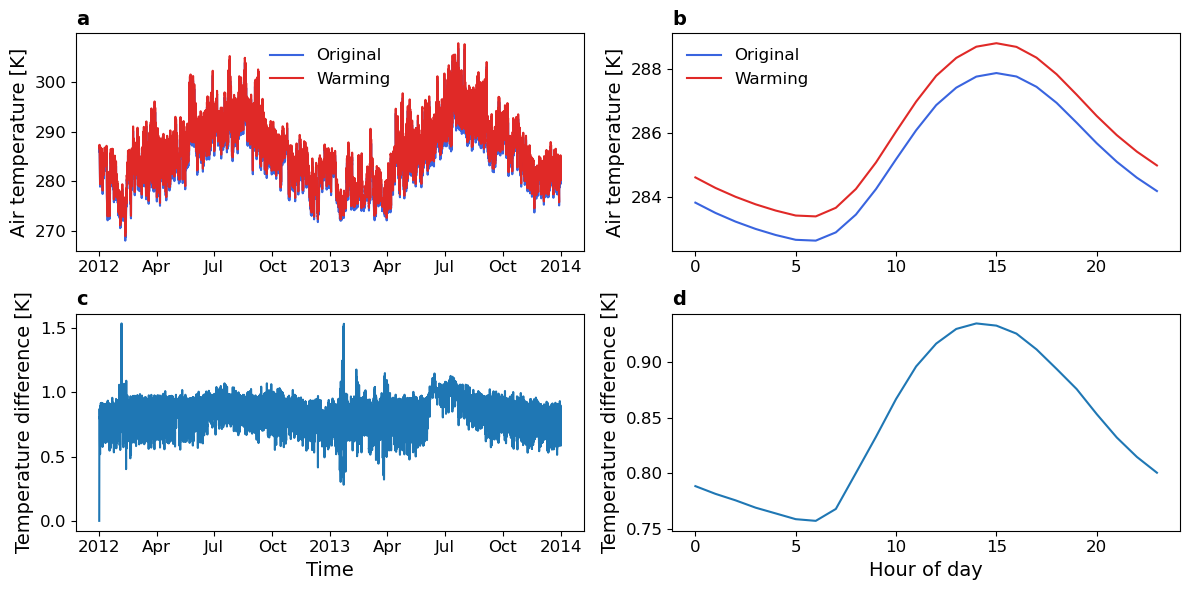

In [6]:
fig = plt.figure(figsize=(12, 6))

# plot the original and warming surface temperature
ax = fig.add_subplot(2, 2, 1)
ds_or_usp['TSA'].isel(gridcell=0).plot(ax=ax, label="Original", color='#3964DF')
ds_warming_usp['TSA'].isel(gridcell=0).plot(ax=ax, label="Warming", color='#E02927')
ax.legend(frameon=False, fontsize=12)

# plot the original and warming surface temperature hourly
ax = fig.add_subplot(2, 2, 2)
def plot_hourly(ds, ax, title, color):
    ds['TSA'].groupby('time.hour').mean().plot(ax=ax, label=title, color=color)

plot_hourly(ds_or_usp, ax, "Original", '#3964DF')
plot_hourly(ds_warming_usp, ax, "Warming", '#E02927')
ax.legend(frameon=False, fontsize=12)

# plot the residual
ax = fig.add_subplot(2, 2, 3)
dd = (ds_warming_usp['TSA']-ds_or_usp['TSA']).isel(gridcell=0).plot()

# plot the residual hourly
ax = fig.add_subplot(2, 2, 4)
dd = (ds_warming_usp['TSA']-ds_or_usp['TSA']).isel(gridcell=0).groupby('time.hour')
mean = dd.mean('time')
var = dd.var('time')
mean.plot(ax=ax)

# set labels
xlabels = ['', '', 'Time', 'Hour of day']
ylabels = ['Air temperature [K]', 'Air temperature [K]', 'Temperature difference [K]', 'Temperature difference [K]']
titles = ['a', 'b', 'c', 'd']
for ax in fig.axes:
    ax.set_xlabel(xlabels.pop(0), fontsize=14)
    ax.set_ylabel(ylabels.pop(0), fontsize=14)
    ax.set_title(titles.pop(0), loc='left', fontweight='bold', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig('figs/example2_usp.pdf', dpi=300)
plt.show()

In [7]:
usp.case_clean(case_name="example2")

**stop and remove the container**

In [8]:
usp.docker("stop")
usp.docker("rm")